In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/philippe/MolGenDocking


/home/philippe/miniconda3/envs/MolGen/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Loading

In [2]:
from pathlib import Path
import json
import re

import pandas as pd
import numpy as np
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import DataStructs

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import roc_curve, roc_auc_score
from notebooks.utils import PandasTableFormatter
from mol_gen_docking.reward.diversity_aware_top_k import diversity_aware_top_k
from notebooks.utils import *

FIG_PATH = "/home/philippe/-Philippe-MolGenDocking/Figures/Results/MolProp"
os.makedirs(FIG_PATH, exist_ok=True)


In [3]:
MOLSTRAL_PATH = Path("MolGenOutput/polaris")

files = [f for f in MOLSTRAL_PATH.iterdir() if "error" not in str(f) and str(f).endswith("scored.jsonl")]
files = sorted(files)
full_df = load_molprop_results(files)

100%|██████████| 7/7 [00:11<00:00,  1.68s/it]


In [4]:
from tqdm import tqdm
tqdm.pandas()

# Metric Computation

## Regression

In [19]:
# Compute Spearman_corr
df = full_df[full_df.objectives == "regression"]
mean = df[df.validity].groupby(["Model", "Task"]).y.mean()
for model in df.Model.unique():
    for task in df.Task.unique():
        if (model, task) not in mean.index:
            mean.loc[(model, task)] = 0
df["t_mean"] = df.progress_apply(
    lambda row: mean.loc[(row.Model, row.Task)],
    axis=1
)


def get_yagg(values):
    values = [v for v in values if v != "invalid"]
    if len(values) == 0:
        return np.nan
    return np.mean(values)

df["y_agg"] = df.groupby(["Model", "prompt_id"]).y.transform(get_yagg)
df['y_agg'] = df.progress_apply(lambda row: row.y_agg if not np.isnan(row.y_agg) else row.t_mean, axis=1)
correlations = df.groupby(["Model", "Task"])[["gt", "y_agg"]].corr(method="spearman").loc[pd.IndexSlice[:, :, "gt"], "y_agg"].fillna(-1)

100%|██████████| 380345/380345 [00:18<00:00, 20836.03it/s]
/tmp/ipykernel_1290082/2239090961.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["t_mean"] = df.progress_apply(
/tmp/ipykernel_1290082/2239090961.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_agg"] = df.groupby(["Model", "prompt_id"]).y.transform(get_yagg)
100%|██████████| 380345/380345 [00:05<00:00, 73459.40it/s]
/tmp/ipykernel_1290082/2239090961.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

## Classification

In [46]:
df = full_df[full_df.objectives == "classification"]
# Compute average answer (projected onto 0,1)
mean = df[df.validity].groupby(["Model", "Task"]).y.mean().apply(np.round)
for model in df.Model.unique():
    for task in df.Task.unique():
        if (model, task) not in mean.index:
            mean.loc[(model, task)] = 0
df["t_mean"] = df.progress_apply(
    lambda row: mean.loc[(row.Model, row.Task)],
    axis=1
)

def get_yagg(values):
    values = [v for v in values if v != "invalid"]
    if len(values) == 0:
        return np.nan
    return np.round(np.mean(values))

df["y_agg"] = df.groupby(["Model", "prompt_id"]).y.transform(get_yagg)
df['y_agg'] = df.progress_apply(lambda row: row.y_agg if not np.isnan(row.y_agg) else row.t_mean, axis=1)
roc_auc = df.groupby(["Model", "Task"])[["gt", "y_agg"]].apply(lambda x: roc_auc_score(x["gt"].to_numpy(), x["y_agg"].to_numpy()))

100%|██████████| 98945/98945 [00:04<00:00, 21029.84it/s]
/tmp/ipykernel_1290082/484393087.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["t_mean"] = df.progress_apply(
/tmp/ipykernel_1290082/484393087.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_agg"] = df.groupby(["Model", "prompt_id"]).y.transform(get_yagg)
100%|██████████| 98945/98945 [00:01<00:00, 76808.87it/s]
/tmp/ipykernel_1290082/484393087.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

## Add to table

In [47]:
full_df["Metric"] = full_df.progress_apply(lambda row: correlations.loc[row.Model, row.Task, "gt"] if row.objectives == "regression" else roc_auc.loc[row.Model, row.Task], axis=1)


100%|██████████| 479290/479290 [00:24<00:00, 19173.08it/s]


# Plots

In [48]:
KEY = "Metric"
table = full_df.groupby(["Model", "Task", "objectives"])[KEY].mean().reset_index()
MODEL_ORDER = list(CMAP_MODELS.keys())

task_order = table.groupby(["Model", "Task"])[KEY].mean().reset_index().groupby("Task")[KEY].max().sort_values( ascending=False).index

table = table.set_index(["Task"]).loc[task_order].reset_index()
table

,Task,Model,objectives,Metric
0,bbb,ChemDFM-R,classification,0.751348
1,bbb,DeepSeek-R1-D.-Llama,classification,0.678922
2,bbb,DeepSeek-R1-D.-Qwen,classification,0.656373
3,bbb,Llama-3.3-Instruct,classification,0.749632
4,bbb,Qwen3-A3B-Think.,classification,0.630270
...,...,...,...,...
184,ld50,DeepSeek-R1-D.-Qwen,regression,-0.112455
185,ld50,Llama-3.3-Instruct,regression,-0.228422
186,ld50,Qwen3-A3B-Think.,regression,-0.198248
187,ld50,ether0,regression,-0.015234


# Barplot

In [49]:
def plot_perfs(table, axes, title_name, split_val, legend=False, ylims = (0,1), metric_name:str = "Spearman Correlation"):
    ax = axes[0]
    sns.barplot(
        data=table[table.objectives == split_val],
        x="Task",
        y=KEY,
        hue="Model",
        ax=ax,
        legend=False,
        # alpha=0.5
        capsize=.02,
        err_kws={"linewidth": .8},
    )
    ax.set_xlabel("")
    ax.set_ylabel(metric_name)
    ax.set_xticklabels(rotation=90, ha='center', labels=ax.get_xticklabels())
    ax.set_title(title_name)
    ax.set_ylim(ylims)

    ax = axes[1]
    sns.barplot(
        data=table[table.objectives == split_val],
        x="objectives",
        y=KEY,
        hue="Model",
        ax=ax,
        legend=legend,
        capsize=.02,
        err_kws={"linewidth": .8},
    )
    ax.set_xlabel("")
    ax.set_xticklabels(rotation=90, ha='center', labels=["Avg."])
    ax.set_title(f"Avg.")
    ax.set_ylabel("")
    ax.set_yticklabels([])
    ax.set_ylim(ylims)


In [50]:
import matplotlib.gridspec as gridspec

/tmp/ipykernel_1290082/4041929049.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(rotation=90, ha='center', labels=ax.get_xticklabels())
/tmp/ipykernel_1290082/4041929049.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(rotation=90, ha='center', labels=["Avg."])
/tmp/ipykernel_1290082/4041929049.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(rotation=90, ha='center', labels=ax.get_xticklabels())
/tmp/ipykernel_1290082/4041929049.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(rotation=90, ha='center', labels=["Avg."])


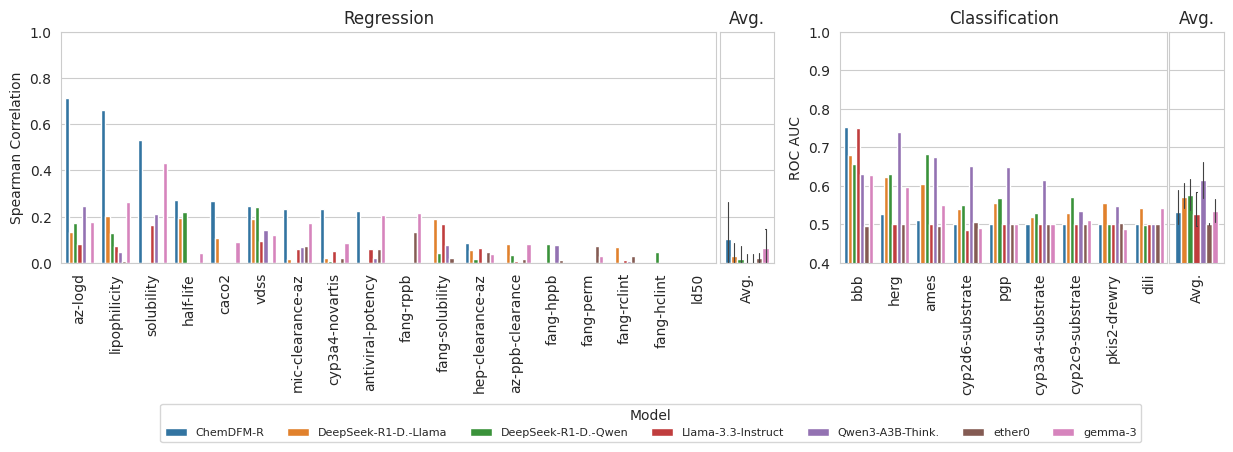

In [51]:
ax_size_ratio = table[table.objectives == "regression"].Task.nunique() / table.Task.nunique()
avg_ratio = ax_size_ratio/12

fig = plt.figure(figsize = (15,3))
outer_gs = gridspec.GridSpec(1, 2, width_ratios=[ax_size_ratio + avg_ratio, 1-ax_size_ratio + avg_ratio], wspace=0.12)
# get the two ax from the outer grid[0]
axes = []
inner_gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_gs[0], wspace=0.01, width_ratios=[ax_size_ratio, avg_ratio])
for i in range(2):
    axes.append(fig.add_subplot(inner_gs[0, i]))
plot_perfs(table, axes, "Regression", "regression", legend=False, ylims=(-0.,1), metric_name="Spearman Correlation")

axes = []
inner_gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_gs[1], wspace=0.01, width_ratios=[1-ax_size_ratio, avg_ratio])
for i in range(2):
    axes.append(fig.add_subplot(inner_gs[0, i]))
plot_perfs(table, axes, "Classification", "classification", legend=True, ylims=(0.4,1), metric_name="ROC AUC")

axes[-1].legend(title="Model", loc="lower center", bbox_to_anchor=(-9.5, -.8), ncols = 8, fontsize = 8, title_fontsize = 10)

fig.savefig(f"{FIG_PATH}/molecular_proppred.pdf", bbox_inches="tight")

# Heatmap

In [52]:
MODEL_ORDER = full_df[full_df.objectives == "classification"].groupby("Model")[KEY].mean().sort_values().index.tolist()

In [53]:
def plot_heatmap(table, axes, title_name, split_val, vmin=0, vmax=1):
    ax = axes[0]
    pivoted = pd.pivot_table(table[table.objectives == split_val], KEY, "Model", "Task")
    col_order = pivoted.mean().sort_values(ascending=False).index
    pivoted = pivoted.loc[MODEL_ORDER,col_order]
    sns.heatmap(
        pivoted,
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        cbar=False,
        annot=True,
        fmt=".2f",
        annot_kws={"size": 8}
    )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels(rotation=90, ha='center', labels=ax.get_xticklabels())
    ax.set_title(title_name)

    ax = axes[1]
    pivoted = pd.pivot_table(table[table.objectives == split_val], KEY, "Model", "objectives")
    pivoted = pivoted.loc[MODEL_ORDER]
    sns.heatmap(
        pivoted,
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        cbar=False,
        annot=True,
        fmt=".2f",
        annot_kws={"size": 8}
    )
    ax.set_xlabel("")
    ax.set_xticklabels(rotation=90, ha='center', labels=["Avg."])
    ax.set_title(f"Avg.\n{title_name}")


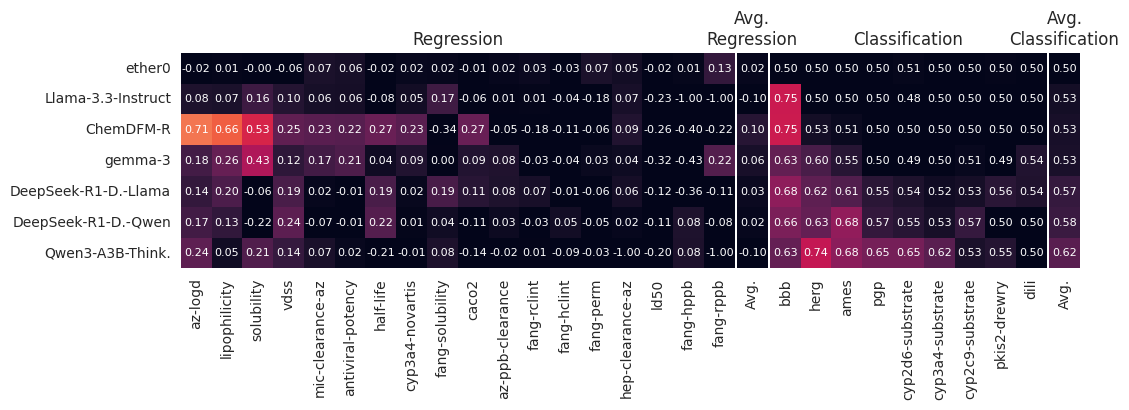

In [54]:
n_tot_cols = table.Task.nunique() + 2
n_rows = table.Model.nunique()

reg_ratio = table[table.objectives == "regression"].Task.nunique() / n_tot_cols
cls_ratio = table[table.objectives == "classification"].Task.nunique() / n_tot_cols

fig, axes = plt.subplots(
    1,
    4,
    figsize = (0.4*n_tot_cols,0.4 * n_rows),
    sharey=True,
    gridspec_kw = {
        "width_ratios":[reg_ratio, 1/n_tot_cols, cls_ratio,  1/n_tot_cols],
        "wspace":0.01,
    }
)

plot_heatmap(table, [axes[0],axes[1]], "Regression", "regression")
plot_heatmap(table, [axes[2],axes[3]], "Classification", "classification", vmin = 0.5, vmax=1)

for ax in axes[1:]:
    ax.set_ylabel("")


In [ ]:
table

In [ ]:
LATEX_PATH = "/home/philippe/-Philippe-MolGenDocking/tables"

In [ ]:
formatter = PandasTableFormatter(
    n_decimals = 3, # Number of decimals to keep in the table
    aggregation_methods=["mean"], # Aggregation functions to apply to the data
    main_subset=0, # Subset of values to bold, here the first column will be bolded corresponding to the mean values, if [0,1] the first two columns will be bolded (independently)
    hide_agg_labels=True, # Hide the aggregation column names in the latex
    global_agg=False # Whether to compute global aggregation across all columns (True)
)

style = formatter.style(
    table, # Dataframe to format
    rows= ["Model", "Size", "Think."], # Rows
    cols="Task", # Columns
    values= KEY, # Values
    highlight_fn= np.nanmax, # Function to use to highlight the values, here the maximum values will be highlighted
    props=["font-weight: bold; text-decoration: underline;"], # Properties to apply to the highlighted values, here the maximum values will be underlined and bolded, the second maximum values will be bolded
    special_format_agg = {
        "std": lambda x: "\\tiny $\\pm$" + x, # Format to apply to the standard deviation values
    },
    remove_col_names=False,
    # row_order = MODEL_ORDER
)
style

In [ ]:
formatter.save_to_latex(style, f"{LATEX_PATH}/gen_table.tex", 1, multicol_align="|c|", hrules=True, n_first_cols=2)
style